In [ ]:
import rasterio as rio
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import geopandas as gpd
from shapely.geometry import mapping
from rasterio.mask import mask

<>:1: SyntaxWarning: invalid escape sequence '\A'
<>:1: SyntaxWarning: invalid escape sequence '\A'
C:\Users\esl26\AppData\Local\Temp\ipykernel_49848\2781205995.py:1: SyntaxWarning: invalid escape sequence '\A'
  shp = gpd.read_file('../data/angola_shp\AGO_adm0.shp')


<Axes: >

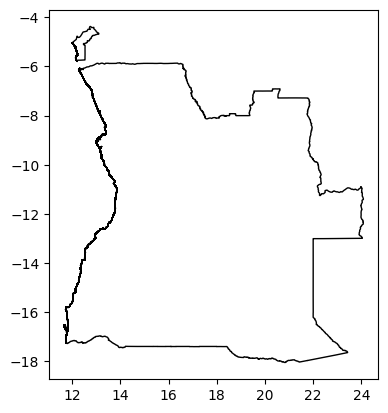

In [200]:
shp = gpd.read_file('../data/angola_shp\AGO_adm0.shp')
shp.geometry.boundary.plot(color=None, edgecolor='k', linewidth = 1)

In [202]:
type(shp.geometry.values[0]), shp.crs, shp.total_bounds

(shapely.geometry.multipolygon.MultiPolygon,
 <Geographic 2D CRS: EPSG:4326>
 Name: WGS 84
 Axis Info [ellipsoidal]:
 - Lat[north]: Geodetic latitude (degree)
 - Lon[east]: Geodetic longitude (degree)
 Area of Use:
 - name: World.
 - bounds: (-180.0, -90.0, 180.0, 90.0)
 Datum: World Geodetic System 1984 ensemble
 - Ellipsoid: WGS 84
 - Prime Meridian: Greenwich,
 array([ 11.66847324, -18.04208183,  24.08211708,  -4.37259102]))

In [172]:
tif_sample1 = "../data/rzsm/2015_04_20.tif"
with rio.open(tif_sample1) as src:
    sm = src.read(1)
    bounds = src.bounds
    crs = src.crs
sm.shape, bounds, crs

((189, 133),
 BoundingBox(left=11.716805458068848, bottom=-17.973846435546875, right=24.040456771850586, top=-4.4174346923828125),
 CRS.from_epsg(4326))

In [ ]:
values = np.unique(sm)[:-1] # remove the NaN value
values, np.min(values), np.max(values)

# Visualize TIFF file

In [ ]:
def viz_tiff(date):
    tif_sample = f"../data/rzsm/{date}.tif"
    with rio.open(tif_sample) as src:
        sm = src.read(1)
        bounds = src.bounds
        crs = src.crs
    fig = plt.figure(figsize=(10, 10))
    img_extent = (bounds.left, bounds.right, bounds.bottom, bounds.top)
    ax = fig.add_axes([0.1, 0.1, 0.8, 0.8], projection=ccrs.epsg(3857)) 

    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=2, color='gray',
                    alpha=0.5, linestyle='--', ylabel_style={'size': 14, 'rotation': 'vertical'}, 
                    xlabel_style={'size': 14}) #TODO: insert line styles later

    gl.xlabels_bottom = False
    gl.ylabels_right = False

    plot = ax.imshow(sm, cmap='GnBu', extent=img_extent)

    cbar_ax = fig.add_axes([0.20, 0.05, 0.6, 0.04])
    cbar = plt.colorbar(plot, cax=cbar_ax, orientation='horizontal', pad=0.05)
    cbar.ax.tick_params(labelsize=16)
    cbar.set_label('RZSM', fontsize=18)

    fig.suptitle(f'{date}', fontsize=20)

    # plt.savefig(f'../figures/rzsm_{date}.png', dpi=300, bbox_inches='tight')

In [ ]:
viz_tiff('2015_05_30')

# Dealing with the porosity data
We have to convert the `porosity_9km.mat` file to numpy array

In [157]:
import scipy.io
mat1 = scipy.io.loadmat('../data/porosity_9km.mat')
mat2 = scipy.io.loadmat('../data/SMAPCenterCoordinates9KM.mat')
mat3 = scipy.io.loadmat('../data/SMAP_Color_SoilMoisture.mat')

In [99]:
data = mat1['porosity']
porosity = np.array(data)
porosity.shape

(1624, 3856)

In [98]:
lat_arr = mat2['SMAPCenterLatitudes']
lon_arr = mat2['SMAPCenterLongitudes']
lat_arr.shape, lon_arr.shape

((1624, 3856), (1624, 3856))

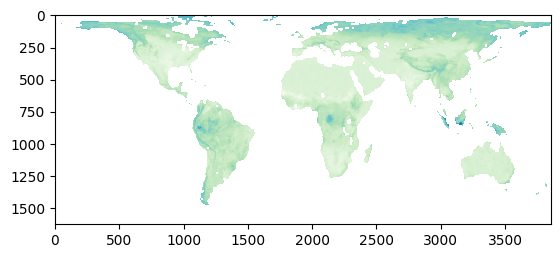

In [100]:
plt.imshow(porosity, cmap='GnBu')

In [101]:
porosity

array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])

In [217]:
with rio.open('../data/porosity_9km.tif') as src:
    data = src.read(1)
    crs = src.crs
    
    # Mask the GeoTIFF file using the shapefile geometry

    geometry = [mapping(shp.geometry.values[0])]
    out_image, out_transform = mask(src, geometry)
data, crs, data.shape

(array([[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]),
 CRS.from_epsg(4326),
 (1624, 3856))

In [219]:
out_transform

Affine(0.09336099585062241, 0.0, -180.0,
       0.0, -0.11083743842364532, 90.0)

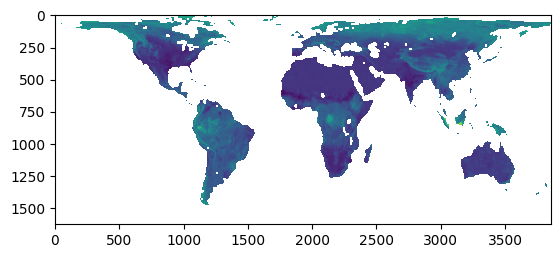

In [216]:
plt.imshow(data)

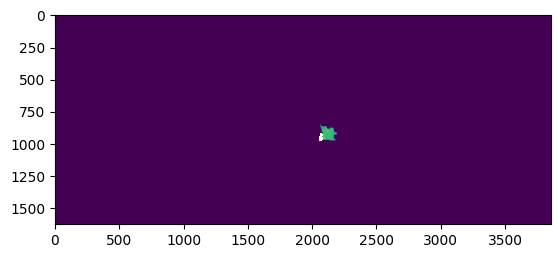

In [218]:
plt.imshow(out_image[0])

In [206]:
from rasterio.crs import CRS

# Define the metadata for the new GeoTIFF file
out_meta = src.meta.copy()
out_meta.update({
    "driver": "GTiff",
    "height": out_image.shape[1],
    "width": out_image.shape[2],
    "transform": out_transform,
    "crs": CRS.from_epsg(4326)
})

# Save the masked area to a new GeoTIFF file
output_tiff_path = '../data/porosity_9km_angola.tif'
with rio.open(output_tiff_path, "w", **out_meta) as dest:
    dest.write(out_image)

In [193]:
with rio.open('../data/porosity_9km_angola.tif') as src:
    data = src.read(1)
    crs = src.crs
    
data, crs, data.shape

(array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 CRS.from_epsg(4326),
 (133, 134))

In [144]:
polygon[0]['coordinates'][0][0]

((11.702361106872672, -16.507638931274414),
 (11.702361106872672, -16.507917404174805),
 (11.702638626098746, -16.507917404174805),
 (11.702638626098746, -16.50819206237793),
 (11.703195571899528, -16.50819206237793),
 (11.703195571899528, -16.508472442626953),
 (11.703471183776855, -16.508472442626953),
 (11.703471183776855, -16.508750915527287),
 (11.70402717590332, -16.508750915527287),
 (11.70402717590332, -16.508472442626953),
 (11.704584121704045, -16.508472442626953),
 (11.704584121704045, -16.508750915527287),
 (11.705694198608398, -16.508750915527287),
 (11.705694198608398, -16.509027481078988),
 (11.706806182861385, -16.509027481078988),
 (11.706806182861385, -16.50930404663086),
 (11.70708370208746, -16.50930404663086),
 (11.70708370208746, -16.50958251953125),
 (11.708193778991813, -16.50958251953125),
 (11.708193778991813, -16.51013946533203),
 (11.708749771118278, -16.51013946533203),
 (11.708749771118278, -16.50958251953125),
 (11.709028244018668, -16.50958251953125),
 (

In [203]:
import numpy as np
import rasterio
from rasterio.transform import from_origin
from scipy.io import loadmat

# Load the porosity data from the .mat file
mat_file = '../data/porosity_9km.mat'
data = loadmat(mat_file)
porosity = data['porosity']
latitudes = mat2['SMAPCenterLatitudes']
longitudes = mat2['SMAPCenterLongitudes']

# Define the transform and metadata for the GeoTIFF
# Assuming latitudes and longitudes are 2D arrays matching the porosity array
lat_min = -90
lat_max = 90
lon_min = -180
lon_max = 180

n_rows, n_cols = porosity.shape
x_res = (lon_max - lon_min) / n_cols
y_res = (lat_max - lat_min) / n_rows
print(porosity.shape)

transform = from_origin(lon_min, lat_max, x_res, y_res)

# Write the porosity data to a GeoTIFF file
output_tiff = '../data/porosity_9km.tif'

with rasterio.open(
    output_tiff,
    'w',
    driver='GTiff',
    height=n_rows,
    width=n_cols,
    count=1,
    dtype=porosity.dtype,
    crs='EPSG:4326',
    transform=transform,
) as dst:
    dst.write(porosity, 1)

print(f"Porosity data has been saved to {output_tiff} with EPSG:4326 projection.")


(1624, 3856)
Porosity data has been saved to ../data/porosity_9km.tif with EPSG:4326 projection.


In [198]:
latitudes.shape, longitudes.shape

((1624, 3856), (1624, 3856))

In [195]:
lat_min, lat_max, lon_min, lon_max

(-84.65644073486328, 84.65644073486328, -179.9533233642578, 179.9533233642578)

In [199]:
transform

Affine(0.09333678597731214, 0.0, -179.9533233642578,
       0.0, -0.1042567004123932, 84.65644073486328)